In [1]:
import cPickle as pkl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

## 1. Model for protein speeds ("tic toc" TRSL output)

General form:

$$v = f(l, t)$$

where $v = \frac{\Delta \mathrm{abundance}}{\Delta t}$: ribosome speed on the gene

$l$: gene length in nts (or codons) (a bit counterintuitive but worth a try)

$t$: adaptation index (tAI or cAI)

### 1.0 Get data

Ribosome speeds:

Lengths:

In [2]:
orf_genomic_dict = pkl.load(open("../../parameters/orf_coding.p"))
len(orf_genomic_dict)

6713

In [3]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [4]:
ribo_speeds = pkl.load(open("../../parameters/tic_toc_speed_dict.p"))
len(ribo_speeds)

4475

tAIs:

In [5]:
tais = pkl.load(open("../../parameters/tAI_codonR.p"))
len(tais)

5917

Total set intersection:

In [6]:
len(orf_lengths.viewkeys() & ribo_speeds.viewkeys() & tais.viewkeys())

4475

So ribosome speeds are the limiting factor, as expected.

### 1.1 Linear regression

General form:

$$v = a_l l + a_t t + c$$

First the univariate scatter plots:

In [7]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2, xlog=True, ylog=True):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-')
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys, color='b', alpha=alpha)
    scat.set_alpha(alpha)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs, missing='raise', return_sorted=True)[:,1]
    
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

4475


KeyboardInterrupt: 

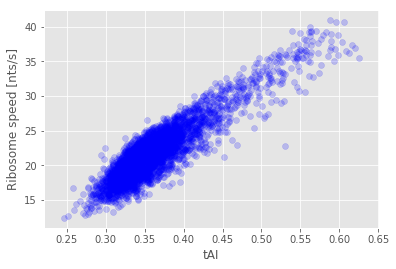

In [8]:
scatter_dicts(tais, ribo_speeds, xaxislabel='tAI', yaxislabel='Ribosome speed [nts/s]', xlog=False, ylog=False)

In [ ]:
scatter_dicts(orf_lengths, ribo_speeds, xlog=False, ylog=False)

We try the univariate model first. (Interesting to see the value of the intercept.)

In [ ]:
regression_data = pd.DataFrame([tais, orf_lengths, ribo_speeds]).transpose()
regression_data.columns = ['tAI', 'ORF length', 'Ribosome speed']

Drop values that have data missing:

In [ ]:
regression_data = regression_data[~regression_data.isnull().any(axis=1)]

In [ ]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## 2. Model for synthetic protein synthesis rates (TRSL output)

General form:

$$r = f(p, l, m, t)$$

where $p$: initiation probability

$l$: gene length in nts (or codons)

$m$: transcript count

$t$: adaptation index (tAI or cAI)

### 2.1 Linear regression

### 2.2 Additive model

### 2.3 Multiplicative model

### 2.4 Using 1.1 or 1.2 as a submodel

## 3. Model for experimental protein synthesis rates